# Visualizing statistical significance with barplots in Python

Wu Sun

Last updated: 2018-11-13

This notebook shows how to add statistical significance annotations to barplots.

In [1]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 150

In [3]:
df = sns.load_dataset("iris")  # the sample dataset

This sample dataset contains sepal and petal measurements of three species of the genus *Iris*: *Iris setosa* (`"setosa"`), *Iris versicolor* (`"versicolor"`), and *Iris vriginica* (`"virginica"`). We will compare the lengths and widths of them for statistical significance with the *t*-test.

In [4]:
df.head()  # head

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
df.describe().transpose()  # summary

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


Let's calculate the means and standard errors for each species, which will be used later in the t-test.

In [6]:
df_mean = df.groupby("species").mean()
df_sem = df.groupby("species").sem()  # standard error of the mean
df_size = df.groupby("species").size()  # sample size; no missing data

Note: `itertools.combinations` is particularly useful for programmatically generating sample pairs for the t-test (two-tailed, unequal variance).

In [7]:
df_ttest = pd.DataFrame(columns=["species_1", "species_2", "variable", "p_value"])

for sp1, sp2 in list(itertools.combinations(df_mean.index.values, 2)):
    for var in df_mean.columns.values:
        pval = stats.ttest_ind_from_stats(
            df_mean.loc[sp1, var],
            df_sem.loc[sp1, var],
            df_size.loc[sp1],
            df_mean.loc[sp2, var],
            df_sem.loc[sp2, var],
            df_size.loc[sp2],
            equal_var=False)[1]
        df_ttest = df_ttest.append({
            "species_1": sp1,
            "species_2": sp2,
            "variable": var,
            "p_value": pval}, ignore_index=True)

In [8]:
df_ttest  # t-test results

,species_1,species_2,variable,p_value
0,setosa,versicolor,sepal_length,3.201643e-80
1,setosa,versicolor,sepal_width,1.683666e-81
2,setosa,versicolor,petal_length,5.232569e-98
3,setosa,versicolor,petal_width,8.125284e-110
4,setosa,virginica,sepal_length,1.224420e-85
5,setosa,virginica,sepal_width,1.178593e-66
6,setosa,virginica,petal_length,2.908079e-99
7,setosa,virginica,petal_width,1.634519e-101
8,versicolor,virginica,sepal_length,1.210353e-60
9,versicolor,virginica,sepal_width,9.612604e-41


The convention of significance notations follows this answer on StackExchange: <https://stats.stackexchange.com/questions/41669/convention-for-symbols-indicating-statistical-significance>. (I couldn't find it in a textbook, though.) It is roughly consistent with R's significance codes, except that R does not have `"****"`.

To label the significance codes on barplots, I need the following helper functions.

In [9]:
def pvalue_to_asterisks(p):
    """Represent p-values in significance notations with asterisks."""
    if p < 0:
        raise ValueError("p-value must not be negative!")
    if p <= 1e-4:
        return "****"
    elif p <= 1e-3:
        return "****"
    elif p <= 1e-2:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return "n.s."


def annotate_stat_sig(ax, points_x, points_y, text, ha="center", va="bottom"):
    """Annotate statistical signficance text on a barplot."""
    ax.plot(points_x, points_y, 'k-', lw=1)
    text_pos_x = (points_x[1] + points_x[2]) * 0.5
    text_pos_y = (points_y[1] + points_y[2]) * 0.5
    ax.text(text_pos_x, text_pos_y, text, ha=ha, va=va)

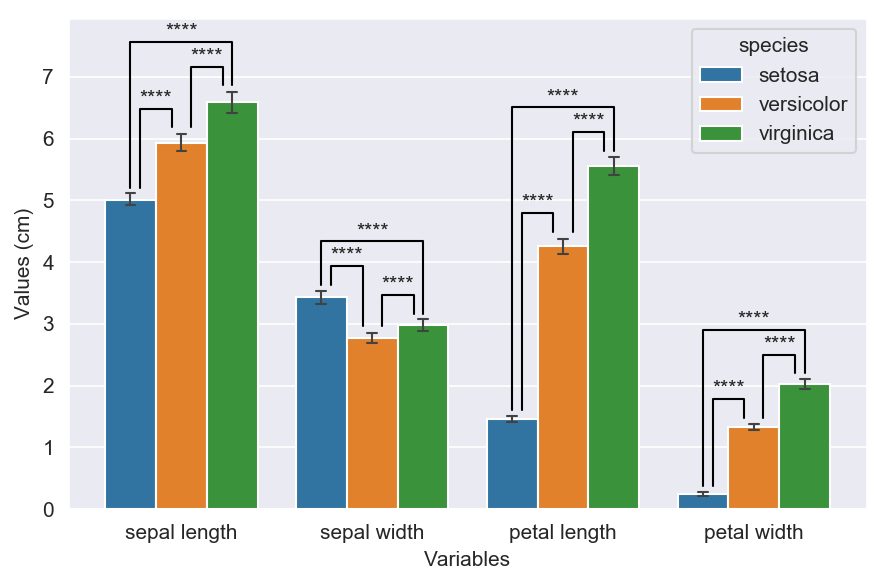

In [11]:
df_melt = pd.melt(df, id_vars=["species"])

ax = sns.barplot(x="variable", y="value", hue="species", data=df_melt,
                 errwidth=1.0, capsize=0.05)
ax.set_xticklabels([
    t.get_text().replace("_", " ") for t in ax.get_xticklabels()])
ax.set_xlabel("Variables")
ax.set_ylabel("Values (cm)")

# add significance annotations
# this has to be done manually
# top of the bar position
bar_tops = [(patch.get_x() + patch.get_width() * 0.5,
             patch.get_y() + patch.get_height()) for patch in ax.patches]
bar_tops = sorted(bar_tops, key=lambda x: x[0])
sp_var_id = list(
    (x, y) for y in df_mean.columns.values for x in df_mean.index.values)

for i in range(df_ttest.shape[0]):
    sp1 = df_ttest.loc[i, "species_1"]
    sp2 = df_ttest.loc[i, "species_2"]
    var = df_ttest.loc[i, "variable"]
    pval = df_ttest.loc[i, "p_value"]
    sig_text = pvalue_to_asterisks(pval)
    # get the anchor points
    pt1 = bar_tops[sp_var_id.index((sp1, var))]
    pt4 = bar_tops[sp_var_id.index((sp2, var))]
    # set margins and bracket height
    hmargin = 0.05
    vmargin = 0.1
    bracket_height = 0.3
    # manual adjustment for the outer bracket
    if (sp1, sp2) == ("setosa", "virginica"):
        hmargin = 0.0
        bracket_height = 0.7
    # adjust for errorbars and add margins
    pt1 = (pt1[0] + hmargin,
           pt1[1] + 2 * df_sem.loc[sp1, var] + vmargin)
    pt4 = (pt4[0] - hmargin,
           pt4[1] + 2 * df_sem.loc[sp2, var] + vmargin)
    y_pos = max(pt1[1] + bracket_height, pt4[1] + bracket_height)
    pt2 = (pt1[0], y_pos)
    pt3 = (pt4[0], y_pos)
    points_x, points_y = zip(pt1, pt2, pt3, pt4)
    annotate_stat_sig(ax, points_x, points_y, sig_text)

plt.tight_layout()

Now this looks much like the barplot + ANOVA results normally produced in R's `ggplot` (see [the example on Stackoverflow](https://stackoverflow.com/questions/15535708/barplot-with-significant-differences-and-interactions/15553486)). It took me about 100 lines of code to reproduce the same style with `matplotlib` and `seaborn` in Python, whereas with `ggplot` it may only take about 10 lines of code. Thus, for this example, `ggplot` beats Python plotting libraries by an order of magnitude in terms of code expressiveness.

But don't get me wrong. I'm not bashing Python or its wonderful plotting packages. Rather, I would see this as an area of improvement. On the other hand, I think knowing a variety of tools or programming languages can be advantageous for a data worker, because then you would know which hammer works best for a certain type of nail.